In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
from haloclustering.models import Model
from haloclustering.data import get_combined_dataset
import haloclustering.evalulate_model as evaluate
# import glob
# from cgmsquared import clustering as cgm2_cluster
# from cgmsquared import load_cgmsquared
# import cgmsquared.clustering2 as c2
# from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
import corner

# Load in the combined CGM$^{2}$ and CASBaH data

In [2]:
cgmsqfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
casdir = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
data = get_combined_dataset(cgmsqfile, casdir)

read_sets: Using set file -- 
  /Users/mwilde/python/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1294
misses 4775
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 292


# define the model


$\chi_{\perp}^{1h} +\chi_{\perp}^{2h}$


$\xi = (r/r_0)^{\gamma}$

where in the 1h term, $r_0 = R_{\rm vir}(m)$, and in the 2-halo term, $r_0$ is a free paramter

$\chi_{\perp} = \int \xi ds$

rate of incidence = $\lambda$



$f_c = 1 - \exp(-\lambda)$

$\lambda = (1 + [\chi_{\perp}^{1h}(r(m)| \gamma^{1h}) + \chi_{\perp}^{2h}(r|r^{2h}_0, \gamma^{2h})])~\langle dN/dz | C_0, \alpha \rangle \delta z$

$\langle dN/dz\rangle = C_0(1 + z)^{\alpha}$


### first perform maximum likelihood estimates of the parameters as a starting point

need to set initial parameters and bounds

In [8]:
r_0_initial = 1 # clustering scale
r_0_2 = 4
beta_initial = 0.5
beta_2_initial = 0.05
gamma_initial = 6 # clutering powerlaw index
gamma_2_initial = 1.7
b_initial = 1. # additive constant to take care of normalization
dndz_index = 1.2 # dN/dz powerlaw index
dndz_coeff = 27
initial = np.array([gamma_initial, r_0_2, gamma_2_initial, dndz_index, dndz_coeff])
bounds = ((0, 10), (0, 10), (0, 2), (-2, 3), (0, 30))


In [9]:
# instantiate the model
rvirModel = Model(data)

In [10]:

# testing
# rvirModel.gamma, rvirModel.r0_2
# rvirModel.r0_rvir
# xi_1h = c2.chi_perp_analytic(rvirModel.r0_rvir, rvirModel.gamma, rvirModel.rho_com, rvirModel.z, rvirModel.Hz, rvirModel.dv)
# xi_2h = c2.chi_perp_analytic(rvirModel.r0_2, rvirModel.gamma, rvirModel.rho_com, rvirModel.z, rvirModel.Hz, rvirModel.dv)
# rvirModel.chi_perp(rvirModel.r0_rvir, rvirModel.gamma)
# rvirModel.chi_perp(rvirModel.r0_2, rvirModel.gamma_2)
# rvirModel.chi_perp(rvirModel.r0_rvir, rvirModel.gamma)
# rvirModel.chi_perp(rvirModel.r0_2, rvirModel.gamma_2)

In [11]:
soln = evaluate.max_likelihood_est(rvirModel, initial, bounds)
gamma, r0_2, gamma_2, dndz_index, dndz_coeff = soln.x

print('\n')
print("Maximum likelihood estimates:")
print("=============================")
print("r0_2 = {0:.3f}".format(r0_2))
print("gamma = {0:.3f}".format(gamma))
print("gamma_2 = {0:.3f}".format(gamma_2))
print('dndz_index = {0:.3f}'.format(dndz_index))
print('dndz_index = {0:.3f}'.format(dndz_coeff))
print("=============================")



Maximum likelihood estimates:
r0_2 = 3.074
gamma = 5.356
gamma_2 = 1.609
dndz_index = 1.347
dndz_index = 29.151


## estimate the posteriors of the model params via MCMC

In [20]:
sampler = evaluate.posterior_sampler(soln, rvirModel.log_probability)


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:03<00:00, 2565.84it/s]


### look at the posterior chains and corner plots

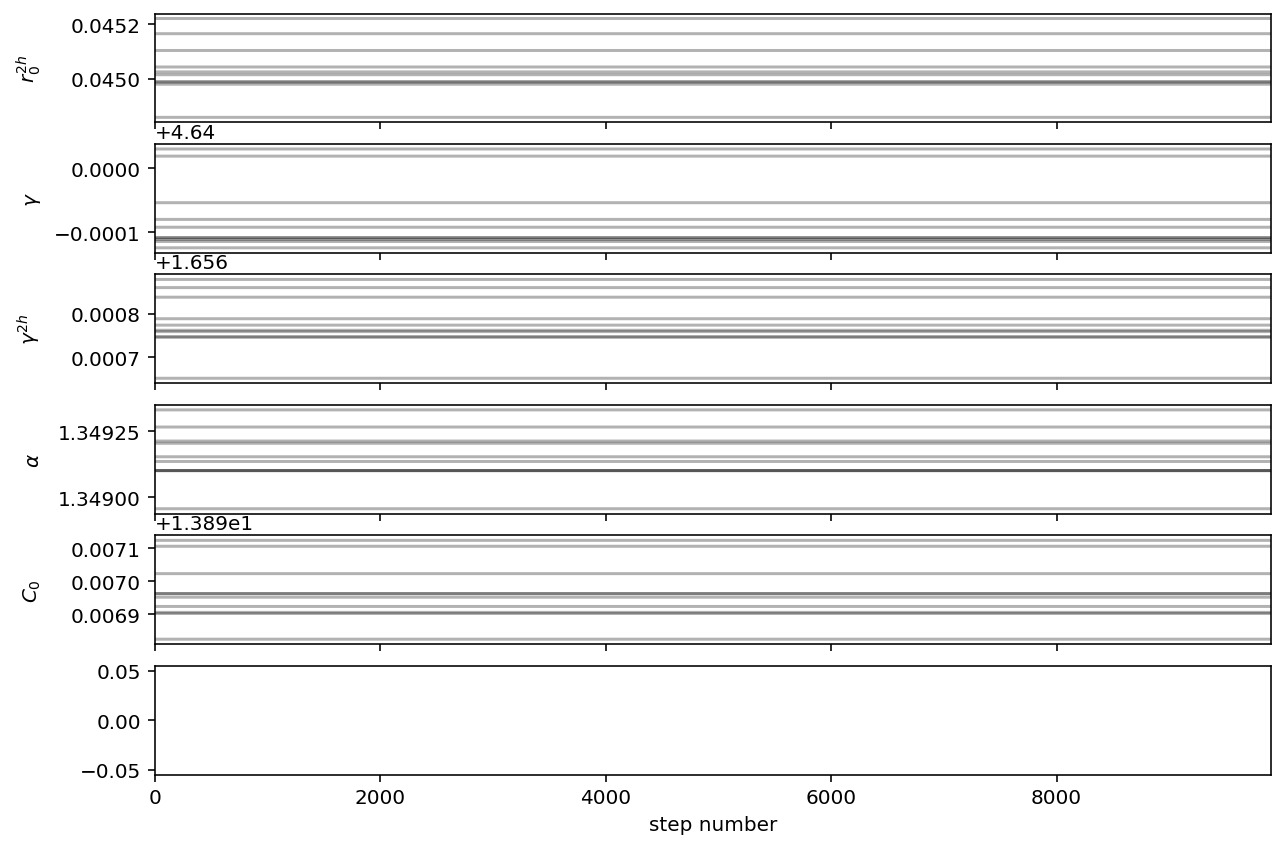

In [21]:
samples = sampler.get_chain(discard=100)
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
ndim = samples.shape[2]

# plot
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 7), sharex=True)
labels = [r"$r_0^{2h}$", r"$\gamma$", r"$\gamma^{2h}$", r'$\alpha$', r'$C_0$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[2000:], "k", alpha=0.3);

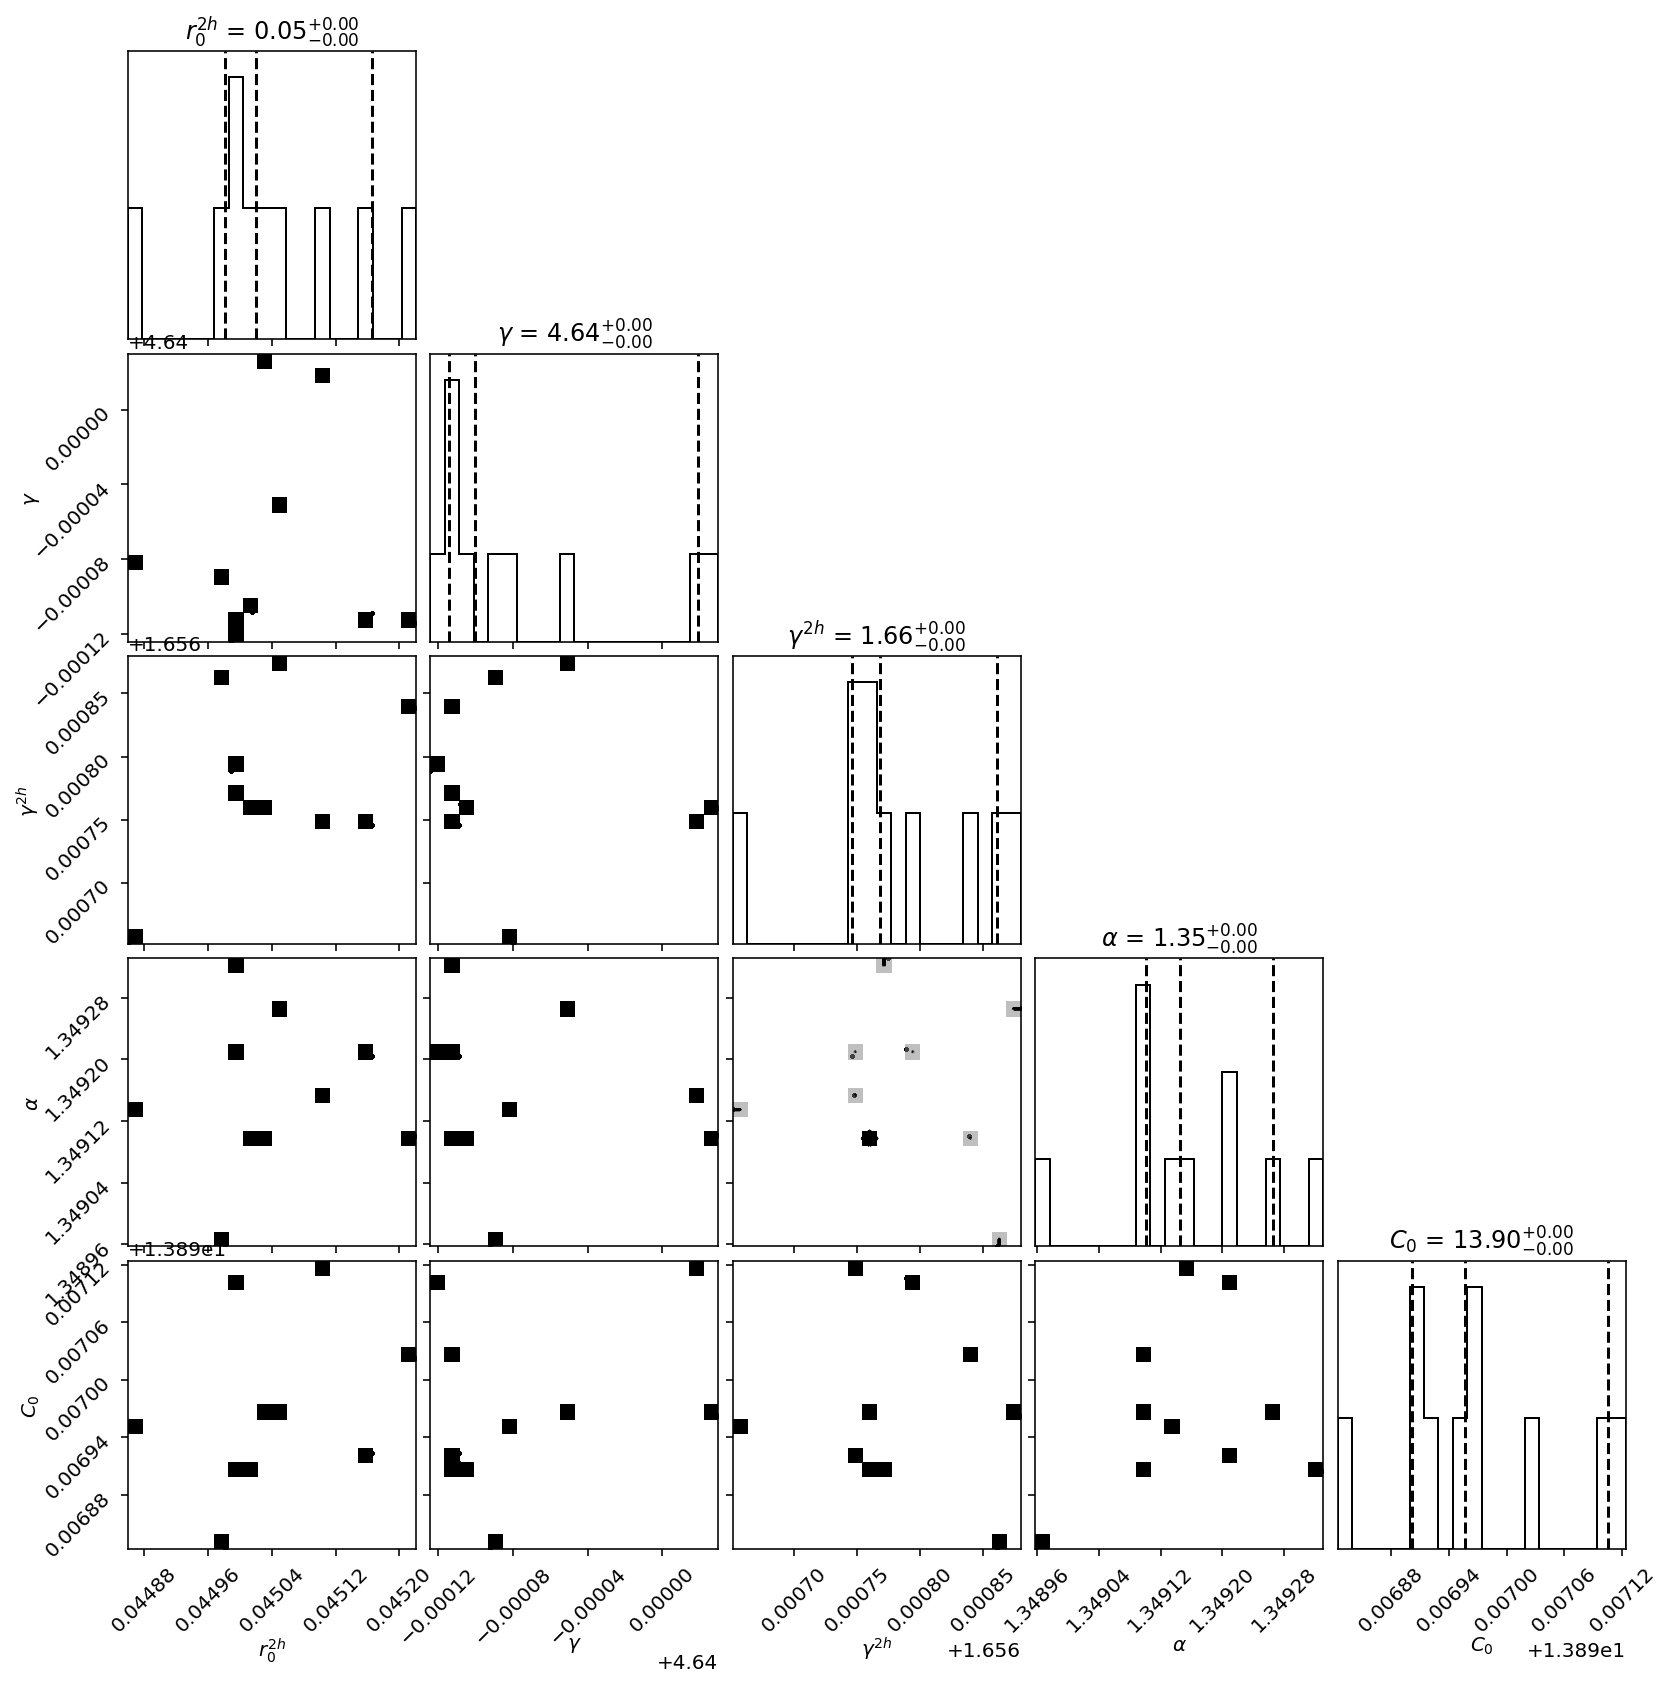

In [22]:
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
);